# Goal:

## Finalize Model and get Integrated Gradients Comparable to DeepLift

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Michael Di Amore
"""

%matplotlib inline
import tensorflow as tf
import Query as query
import quandl 
import numpy as np
# np.random.seed(12345) # Set seed

import pandas as pd
from imblearn.combine import SMOTEENN 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.decomposition import PCA


import pdb
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score
import warnings
import matplotlib.pyplot as plt

import tensorflow as tf
import edward as ed

import keras
import tensorflow.contrib.keras as k


Using TensorFlow backend.


In [2]:
keras.__version__

'2.1.1'

## Load Data

In [3]:
####
#  Load Data. If you don't want to / can't run the query.
# Basically this is all data from 2007-01-01 to 2017-10-06
load_data = True
if load_data == True:
    print ('Loading Data...')
    
    df_2000_2006 = pd.read_csv('Gdelt_events_20000101_20061231.csv')
    df_2000_2006 = df_2000_2006.set_index('sqldate',drop=True).sort_index()
    df_2007_2009 = pd.read_csv('Gdelt_events_20070101_20091231_BUS_ALL.csv')
    df_2007_2009 = df_2007_2009.set_index('sqldate',drop=True).sort_index()
    df_2010_2011 = pd.read_csv('Gdelt_events_20100101_20111231_BUS_ALL.csv')
    df_2010_2011 = df_2010_2011.set_index('sqldate',drop=True).sort_index()
    df_2012_2013 = pd.read_csv('Gdelt_events_20120101_20131231_BUS_ALL.csv')
    df_2012_2013 = df_2012_2013.set_index('sqldate',drop=True).sort_index()
    df_201401_201406 = pd.read_csv('Gdelt_events_20140101_20140631_BUS_ALL.csv')
    df_201401_201406 = df_201401_201406.set_index('sqldate',drop=True).sort_index()
    df_201407_201501 = pd.read_csv('Gdelt_events_20140701_20150101_BUS_ALL.csv')
    df_201407_201501 = df_201407_201501.set_index('sqldate',drop=True).sort_index()
    df_201502_201506 = pd.read_csv('Gdelt_events_20150102_20150601_BUS_ALL.csv')
    df_201502_201506 = df_201502_201506.set_index('sqldate',drop=True).sort_index()
    df_201506_201512 = pd.read_csv('Gdelt_events_20150602_20151231_BUS_ALL.csv')
    df_201506_201512 = df_201506_201512.set_index('sqldate',drop=True).sort_index()
    df_201601_201606 = pd.read_csv('Gdelt_events_20160101_20160631_BUS_ALL.csv')
    df_201601_201606 = df_201601_201606.set_index('sqldate',drop=True).sort_index()
    df_201607_201612 = pd.read_csv('Gdelt_events_20160701_20161231_BUS_ALL.csv')
    df_201607_201612 = df_201607_201612.set_index('sqldate',drop=True).sort_index()
    df_201701_201710 = pd.read_csv('Gdelt_events_20170101_20171006_BUS_ALL.csv')
    df_201701_201710 = df_201701_201710.set_index('sqldate',drop=True).sort_index()

    
    
    gdelt_df = pd.concat([df_2000_2006,df_2007_2009,df_2010_2011,df_2012_2013,df_201401_201406,df_201407_201501,
                          df_201502_201506,df_201601_201606,df_201607_201612,df_201701_201710])
    
    del df_2000_2006,df_2007_2009,df_2010_2011,df_2012_2013,df_201401_201406,df_201407_201501
    del df_201502_201506,df_201601_201606,df_201607_201612,df_201701_201710
####

Loading Data...


## Set Model Params and Load Yahoo Data
### Note Yahoo API is unstable and may fail

In [4]:
# Set Params
lookback_window = int(np.round(252/2))
number_stdev = 3.5
proj_id = 'capstone-v0'
start_date = '2000-01-01'
end_date = '2017-10-06'
ticker = '^GSPC'
my_query = query.query_tool(proj_id,start_date,end_date,ticker)
sql_query = """
            SELECT Actor1Name, GoldsteinScale,NumMentions,sourceurl,
            sqldate, avgtone, numarticles, numsources,  
            FROM [gdelt-bq:full.events] 
            WHERE sqldate > 20010101 and sqldate <= 20061231  and 
            Actor1Code like '%BUS% "
            """
if load_data == False:
    print ('Querying Gdelt...')
    my_query.query_gdelt(sql_query)
    my_query.gdelt_df = my_query.gdelt_df.set_index('sqldate',drop=True).sort_index()
    df = my_query.gdelt_df.copy(True)

#Creating Labels. i.e. if change in spx_return is x standard deviations
security_prices = my_query.query_yahoo()
security_return_for_df = np.log(security_prices['Adj Close']).diff() #log Return
security_return = np.log(security_prices['Adj Close']).diff() #log Return
security_vol = security_return.rolling(window=lookback_window).std().dropna()
security_mean = security_return.rolling(window=lookback_window).mean().dropna()
security_vol.name = 'Volatility'
security_return = security_return.loc[security_vol.index] #First entry is NAN because of return
event_idx = [(np.abs(security_mean)+(security_vol * 3.5)) < np.abs(security_return)]
event_idx = [((security_mean + security_vol * number_stdev) < security_return) | ((security_mean - security_vol *number_stdev) > security_return) ]
event_idx = np.array(event_idx).astype(int).flatten()
# event_idx =  create_event_idx(security_return,security_mean,security_vol,number_stdev)
event_idx = pd.Series(event_idx,index=security_return.index)
print ('Data Loaded')

Data Loaded


## Load Quandl Data

In [5]:
api_key = pd.read_table('api_key.txt',header=None)
api_key =  api_key[0][0]
wti_co = my_query.query_quandl("FRED/DCOILWTICO",api_key)
unemploy = my_query.query_quandl("FRED/UNEMPLOY",api_key)
m1v = my_query.query_quandl("FRED/M1V",api_key)
m2v = my_query.query_quandl("FRED/M2V",api_key)
stressindex = my_query.query_quandl("FRED/STLFSI", api_key)
dff = my_query.query_quandl("FRED/DFF",api_key)
my_query.set_ticker('^VIX')
vix = my_query.query_yahoo()
vix = vix['Adj Close']
vix.name = 'VIX'
print ('Quandl Loaded')

Quandl Loaded


In [6]:
quandl_others = pd.concat([wti_co,unemploy,m1v,m2v,stressindex,vix,dff],axis=1)
quandl_others.columns = ['wti_co','unemploy','m1v','m2v','slsi','vix','dff']
quandl_others.ffill(inplace=True)
quandl_others.fillna(0,inplace=True)

In [7]:
def normalize_ts(series,lookback=lookback_window):
    rolling_mean = series.rolling(window=lookback).mean()
    rolling_std = series.rolling(window=lookback).std() + .10**3
    normalized = (series-rolling_mean)/rolling_std
    normalized = normalized.dropna()
    return(normalized)

In [8]:
def weight_gdelt(series,num_articles):
    if series.name != 'numarticles':
        return(series/num_articles)
    else:
        return (num_articles)

## Scale data and collapse GDELT into daily format

In [9]:
#Collapse numerical data into x,y pairs by taking means
collapsed = gdelt_df[['GoldsteinScale','numarticles','NumMentions','avgtone','numsources']]
collapsed = collapsed.apply(lambda x: weight_gdelt(x,gdelt_df['numarticles']))
collapsed =collapsed.groupby(by=gdelt_df.index).mean()

#Shift data so as only to use yesterday's news for tomorrow's prediction
#i.e. we shift forward, using yesterday data as today
collapsed_shifted = collapsed.shift(1)
quandl_shifted = quandl_others.shift(1)
spy_shifted = pd.DataFrame(security_prices).shift(1)

#Scale the data in such a way that we aren't looking forward into the feature
print ('Scaling using custom scaler')
collapsed_shifted = collapsed_shifted.apply(normalize_ts)
quandl_shifted = quandl_shifted.apply(normalize_ts)
spy_shifted = spy_shifted.apply(normalize_ts)

collapsed_shifted.index = pd.to_datetime(collapsed_shifted.index,format='%Y%m%d')
collapsed_shifted = collapsed_shifted.loc[security_vol.index].dropna()
collapsed_shifted = pd.concat([collapsed_shifted,quandl_shifted,spy_shifted],axis=1)
event_idx = event_idx.dropna()


# collapsed_shifted = quandl_shifted
collapsed_shifted = collapsed_shifted.loc[event_idx.index][1:] 
event_idx = event_idx[1:]

Scaling using custom scaler


In [10]:
print ('Creating train test split...')
X_train,X_test,Y_train,Y_test = train_test_split(collapsed_shifted,event_idx,stratify=None,test_size=.20,shuffle=False)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=.20,stratify=None,shuffle=False)

#Creating Copies of Data Frames these will be useful later for debugging
X_train_df = X_train.copy(True)
Y_train_df = Y_train.copy(True)
Y_val_df = Y_val.copy(True)
Y_test_df = Y_test.copy(True)
X_train  = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

Creating train test split...


In [11]:
print ('Length of X_train before smote')
print (len(X_train))
print ('Number of Positives before smote')
print (len((np.where(Y_train==1))[0].flatten()))
# print ('Number of Negative examples before smote')
# print (len((np.where(Y_train==2))[0].flatten()))

s = SMOTEENN()
X_train,Y_train = s.fit_sample(X_train,Y_train)

print ('Length of X_train')
print (len(X_train))



Length of X_train before smote
2779
Number of Positives before smote
11
Length of X_train
5484


In [12]:
X_train = X_train.reshape(-1,X_train.shape[1],1)
X_test = X_test.reshape(-1,X_test.shape[1],1)
X_val = X_val.reshape(-1,X_val.shape[1],1)
D = X_train.shape[1]
Y_val = np.array(Y_val)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
Y_train = Y_train.astype(np.int32)
Y_val = Y_val.astype(np.int32)
Y_train = Y_train.reshape(-1,1).flatten()
Y_val = Y_val.reshape(-1,1).flatten()
Y_test = np.array(Y_test).reshape(-1,1).flatten()


In [13]:
nh1 = 512
nh2 = 256
nh3 = 128
sess = tf.Session(graph=tf.get_default_graph())
data = tf.placeholder(dtype=tf.float32,shape=[None,D,1])
labels = tf.placeholder(dtype=tf.float32,shape=[None,1])
is_training = tf.placeholder(tf.bool)


## Keras Model - 2.0


In [14]:
from keras.layers import Conv1D,Dropout,BatchNormalization,Input,Flatten,MaxoutDense,Dense
from keras.constraints import maxnorm
from keras import backend as K

In [15]:
from keras.constraints import maxnorm
from keras.legacy.layers import MaxoutDense
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.models import Model


def simple_keras_model(original,sess):
    K.set_session(sess)
    
    original_input = Input(shape=(original.shape[1],1),name='orig')
    layer1 =  Conv1D(nh1, 5, padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(original_input)
    layer1 = BatchNormalization()(layer1)
    layer1 = Dropout(.55)(layer1)
    
    layer2 = Conv1D(nh1,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer1)
    layer2 = BatchNormalization()(layer2)
    layer2 = Dropout(.55)(layer2)
    
    layer3 = Conv1D(nh2,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer2)
    layer3 = BatchNormalization()(layer3)
    layer3 = Dropout(.55)(layer3)

    layer4 = Conv1D(nh3,5,padding='same',activation='relu',kernel_initializer='he_normal',kernel_constraint=maxnorm(0.5))(layer3)
    layer4 = BatchNormalization()(layer4)
    layer4 = Dropout(.55)(layer4)
    
    
    layer5 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer4)
    layer5 = BatchNormalization()(layer5)
    layer5 = Dropout(.35)(layer5)
    

    layer6 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer5)
    layer6 = BatchNormalization()(layer6)
    layer6 = Dropout(.35)(layer6)
    
    
    layer7 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer6)
    layer7 = BatchNormalization()(layer7)
    layer7 = Dropout(.35)(layer7)
    
    
    layer8 = Conv1D(nh3,3,padding='same',activation='relu',kernel_initializer='he_normal')(layer7)
    layer8 = BatchNormalization()(layer8)
    layer8 = Dropout(.35)(layer8)
    layer8 = Flatten()(layer8)
    
    
#     layer9 = MaxoutDense(1024,init='he_normal')(layer8)
#     layer9 = BatchNormalization()(layer9)
    
#     layer10 = MaxoutDense(512,init='he_normal')(layer9)
#     layer10 = BatchNormalization()(layer10)
    
#     layer11 = MaxoutDense(128,init='he_normal')(layer10)
#     layer11 = BatchNormalization()(layer11)

    layer9 = Dense(1024,kernel_initializer='he_normal')(layer8)
    layer9 = BatchNormalization()(layer9)
    
    layer10 = Dense(512,kernel_initializer='he_normal')(layer9)
    layer10 = BatchNormalization()(layer10)
    
    layer11 = Dense(128,kernel_initializer='he_normal')(layer10)
    layer11 = BatchNormalization()(layer11)
    
    output = Dense(2,activation='softmax',name='last_layer_dense')(layer11)

    

    my_model = Model([original_input], output=output)
    optimizer_adam = keras.optimizers.adam(0.001) 
    my_model.compile(loss='categorical_crossentropy', optimizer=optimizer_adam, metrics=['accuracy'])


    return(my_model)

In [16]:
#For Softmax
Y_train = keras.utils.to_categorical(num_classes=2,y=Y_train)

In [17]:
my_model = simple_keras_model(X_train,sess)
my_model.fit(X_train,Y_train,epochs=35,batch_size=128)

/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:72: UserWarning: Update your `Model` call to the Keras 2 API: `Model([<tf.Tenso..., outputs=Tensor("la...)`


Epoch 1/35
5484/5484 [==============================] - 9s 2ms/step - loss: 0.3881 - acc: 0.8587
Epoch 2/35
5484/5484 [==============================] - 3s 472us/step - loss: 0.1883 - acc: 0.9349
Epoch 3/35
5484/5484 [==============================] - 3s 471us/step - loss: 0.1259 - acc: 0.9557
Epoch 4/35
5484/5484 [==============================] - 3s 470us/step - loss: 0.0931 - acc: 0.9692
Epoch 5/35
5484/5484 [==============================] - 3s 470us/step - loss: 0.0708 - acc: 0.9783
Epoch 6/35
5484/5484 [==============================] - 3s 471us/step - loss: 0.0534 - acc: 0.9845
Epoch 7/35
5484/5484 [==============================] - 3s 470us/step - loss: 0.0506 - acc: 0.9865
Epoch 8/35
5484/5484 [==============================] - 3s 470us/step - loss: 0.0453 - acc: 0.9880
Epoch 9/35
5484/5484 [==============================] - 3s 470us/step - loss: 0.0409 - acc: 0.9865
Epoch 10/35
5484/5484 [==============================] - 3s 472us/step - loss: 0.0392 - acc: 0.9914
Epoch 11/35

## Data Post Processing

In [18]:
#For last layer sigmoid activation
def proba_to_label(pred,threshold):
    ones = np.array([pred > threshold])
    ones = ones.flatten()
    return (ones)

In [19]:
#For last layer softmax activation
def softmax_to_label(pred):
    ones = np.argmax(pred,1)
    return(ones)

In [20]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc, average_precision_score

### Grouped:
Since our model was predicting events before and after they happened, we decided to group them. We set a stride window, by default it's 5. So that any predictions within 5 days of an actual event are grouped into that event

In [21]:
stride = 5

In [22]:
def grouped(Y,predicted_class,stride,backward_only=False):
    new_preds = np.zeros(len(Y))
    for i in range(len(Y)):
        if i - stride < 0:
            rolling_pred_window = predicted_class[0:i]
            rolling_val_window = Y[0:i]
        else:
            if backward_only == True:
                rolling_pred_window = predicted_class[i-stride:i+1]
                rolling_val_window = Y[i-stride:i+1]
            else:                
                rolling_pred_window = predicted_class[i-stride:i+stride+1]
                rolling_val_window = Y[i-stride:i+stride+1]

            
        
        if rolling_pred_window.any() == True and rolling_val_window.any() == True:
            new_preds[i] = Y[i]
        elif predicted_class[i] == True and Y[i] == False:
            new_preds[i] = True
    return(new_preds)

## Predictions on Validation Set

In [23]:
probas = my_model.predict(X_val)
predicted_classes = softmax_to_label(probas)
predicted_classes
new_preds = grouped(Y_val_df,predicted_classes,stride)
Y_val = np.array(Y_val_df)

In [24]:
Y_val_to_save = pd.DataFrame([Y_val,predicted_classes])
Y_val_to_save = Y_val_to_save.T
Y_val_to_save.columns = ['Truth','Pred']
Y_val_to_save.index = Y_val_df.index
Y_val_to_save.to_csv('val_set_pred_'+str(number_stdev))

## Results on Validation Set

In [25]:
acc = accuracy_score(Y_val,new_preds)
f1 = f1_score(Y_val,new_preds)
roc = roc_auc_score(Y_val,new_preds)
prec = precision_score(Y_val,new_preds)
recall2= recall_score(Y_val,new_preds)


precision, recall, _ = precision_recall_curve(Y_val,new_preds)
avg_prec = average_precision_score(Y_val,new_preds)
area_under_prec_rec = auc(x=recall,y=precision)

print (' On Validation Set')
print (' Standard Deviations: {}'.format(number_stdev))
print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall2))
print (' Area under PR curve {}'.format(area_under_prec_rec))

 On Validation Set
 Standard Deviations: 3.5
 Accuracy: 0.9669064748201439
 F1: 0.20689655172413793
 RoC: 0.9833815028901733
 Precision: 0.11538461538461539
 Recall: 1.0
 Area under PR curve 0.5576923076923077


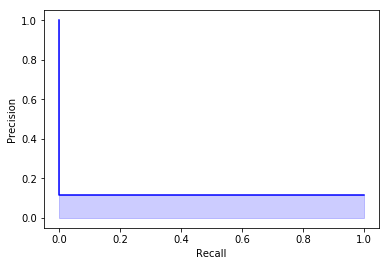

In [26]:
plt.step(recall, precision, color='b',
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')

## Visualizations

In [27]:
def plot_figs(Y,label,indices,pos_or_neg=1):
    plt.figure()
    indices.loc[Y.index].plot()
    position = Y.index[np.where(Y==pos_or_neg)]
    for xc in position:
        plt.axvline(x=xc, color='r', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

    plt.figure()
    indices.loc[Y.index].plot()
    label_position = Y.index[np.where(label==pos_or_neg)]
    for xc in label_position:
        plt.axvline(x=xc, color='b', linestyle='solid',linewidth=.55)
    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')
        
        
    plt.figure()
    indices.loc[Y.index].plot()
    matching_idx = np.intersect1d(np.where(label==pos_or_neg), np.where(Y==pos_or_neg))
    matching_position = Y.index[matching_idx]
    for xc in matching_position:
        plt.axvline(x=xc, color='g', linestyle='solid',linewidth=.55)


    plt.legend()
    plt.ylabel('Index Level')
    plt.xlabel('Time')

In the graphs below solid red vertical lines are actual events, solid blue lines are predicted events, and solid green lines are intersections between the red and blue sets

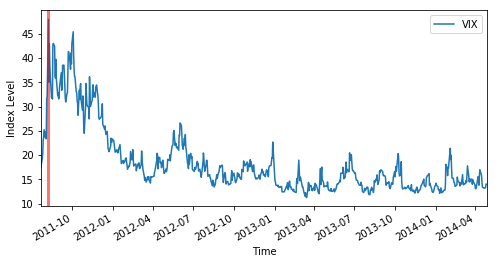

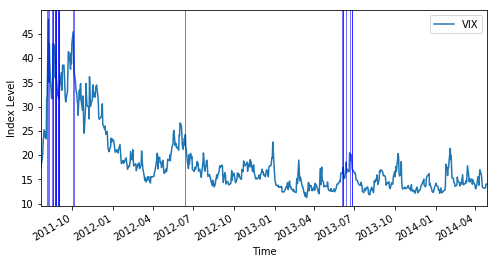

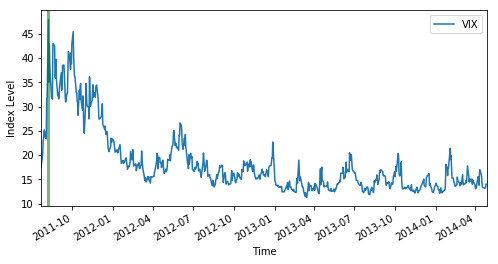

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 8,4
plot_figs(Y_val_df,new_preds,vix,1)

In [29]:
print(np.where(predicted_classes==1)) # Where our predictions said there were events
print(np.where(Y_val==1)) #Where there actually were events

(array([  6,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  27,  28,  29,  30,  50,  51, 224, 467,
       469, 470, 475, 481, 483, 484]),)
(array([ 9, 11, 12]),)


In [30]:
# predicted_classes_test = my_model.predict(X_test)
# predicted_classes_test = np.argmax(predicted_classes_test,axis=1)
proba_for_ig = my_model.predict(X_test)
pred_for_ig_test = softmax_to_label(proba_for_ig)
new_pred_for_ig_test = grouped(Y_test,pred_for_ig_test,stride)

In [31]:
Y_test_to_save = pd.DataFrame([Y_test,pred_for_ig_test,new_pred_for_ig_test])
Y_test_to_save = Y_test_to_save.T
Y_test_to_save.columns = ['Truth','OriginalPred','GroupedPred']
Y_test_to_save.index = Y_test_df.index
Y_test_to_save.to_csv('test_set_pred_'+str(number_stdev))

In [32]:
acc = accuracy_score(Y_test,new_pred_for_ig_test)
f1 = f1_score(Y_test,new_pred_for_ig_test)
roc = roc_auc_score(Y_test,new_pred_for_ig_test)
prec = precision_score(Y_test,new_pred_for_ig_test)
recall2= recall_score(Y_test,new_pred_for_ig_test)


precision, recall, _ = precision_recall_curve(Y_test,new_pred_for_ig_test)
area_under_prec_rec = auc(x=recall,y=precision)

print (' On Test Set')
print (' Standard Deviations: {}'.format(number_stdev))
print (' Accuracy: {}'.format(acc))
print (' F1: {}'.format(f1))
print (' RoC: {}'.format(roc))
print (' Precision: {}'.format(prec))
print (' Recall: {}'.format(recall2))
print (' Area under PR Curve {}'.format(area_under_prec_rec))

 On Test Set
 Standard Deviations: 3.5
 Accuracy: 0.9378596087456847
 F1: 0.12903225806451613
 RoC: 0.8032058709926612
 Precision: 0.07142857142857142
 Recall: 0.6666666666666666
 Area under PR Curve 0.37019836703381004


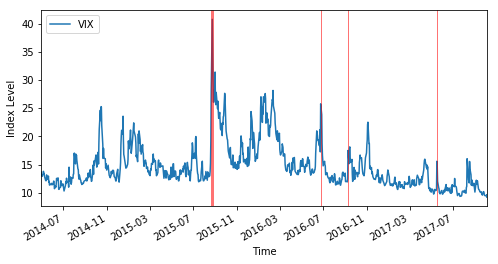

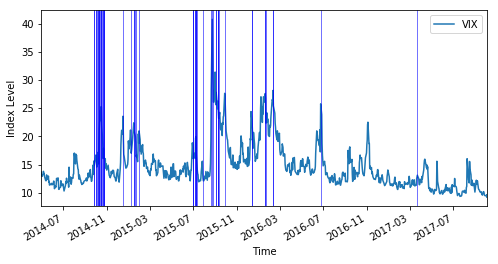

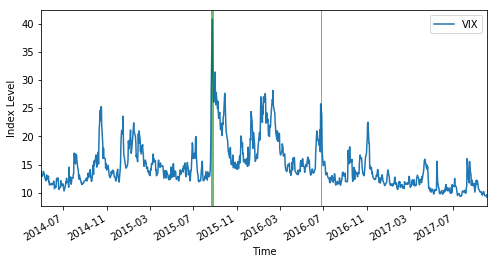

In [33]:
plot_figs(Y_test_df,new_pred_for_ig_test,vix,1)

In [34]:
print(np.where(new_pred_for_ig_test==1)) # Where our predictions said there were events
print(np.where(Y_test==1)) #Where there actually were events

(array([103, 105, 107, 108, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 162, 175, 181, 182, 183, 184,
       190, 295, 296, 297, 298, 299, 300, 301, 302, 303, 314, 332, 333,
       335, 341, 342, 343, 344, 345, 346, 358, 411, 412, 434, 435, 436,
       450, 452, 544, 731]),)
(array([332, 333, 335, 544, 597, 769]),)


# Integrated Gradients 1

Implementation adapted from example codegenerously given by the authors of the paper on their github
#Adjusted from https://github.com/ankurtaly/Integrated-Gradients/blob/master/attributions.ipynb


In [35]:
Y_train_new = np.argmax(Y_train,axis=1)
# Y_train_new = Y_train

In [36]:
def T(layer,graph):
    #Helper for getting layer output tensor
    return graph.get_tensor_by_name(layer)

def scorer(sess,tensor,data):
      return sess.run(tensor, {'orig:0':data,is_training:False,K.learning_phase():0})
    
def top_label_and_score(data,graph,sess):
    '''
    Returns the label and score of the object class
    that receives the highest SOFTMAX score.
    '''
    # Evaluate the SOFTMAX output layer for the image and
    # determine the label for the highest-scoring class
    t_softmax = tf.reduce_mean(T('last_layer_dense/Softmax:0',graph), reduction_indices=0)
#     t_softmax = T('dense_3/Sigmoid:0',graph)
    scores = scorer(sess, t_softmax, data)
    id = np.argmax(scores)
    return Y_train_new[id], scores[id]

def output_label_tensor(label,graph):
    '''Returns a tensor (shape: scalar) representing the SOFTMAX
     for a given label.
    '''
    lab_index = np.where(np.in1d(Y_train, label))[0][0]
    lab_index = lab_index.astype(np.int32)
#     t_softmax = T('dense_3/Sigmoid:0',graph)
    t_softmax = tf.reduce_sum(T('last_layer_dense/Softmax:0',graph), reduction_indices=0)

    return t_softmax[lab_index]

def integrated_gradients(data, label,graph,sess):
    '''
     Returns attributions for the prediction label based
     on integrated gradients at the image.

     Specifically, the method returns the dot product of the image
     and the average of the gradients of the prediction label (w.r.t.
     the image) at uniformly spaced scalings of the provided data.

    '''
    t_output = output_label_tensor(label,graph)  # shape: scalar
    t_grad = tf.gradients(t_output, T('orig:0',graph))[0]
    grads = scorer(sess, t_grad, data)
    return data*np.average(grads, axis=0)

Predict on X_train and get predictions from probas

In [37]:
sess = K.get_session()
intgrads = []
# Determine top label and score.
# for i in range(len(X_train)):
top_label, score = top_label_and_score(X_train.reshape(-1,D,1),sess.graph,sess)
intgrads_attrs = integrated_gradients(X_train.reshape(-1,D,1), top_label,sess.graph,sess)


Get session and graph for Integrated Gradients

Populating the interactive namespace from numpy and matplotlib


/home/ubuntu/src/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


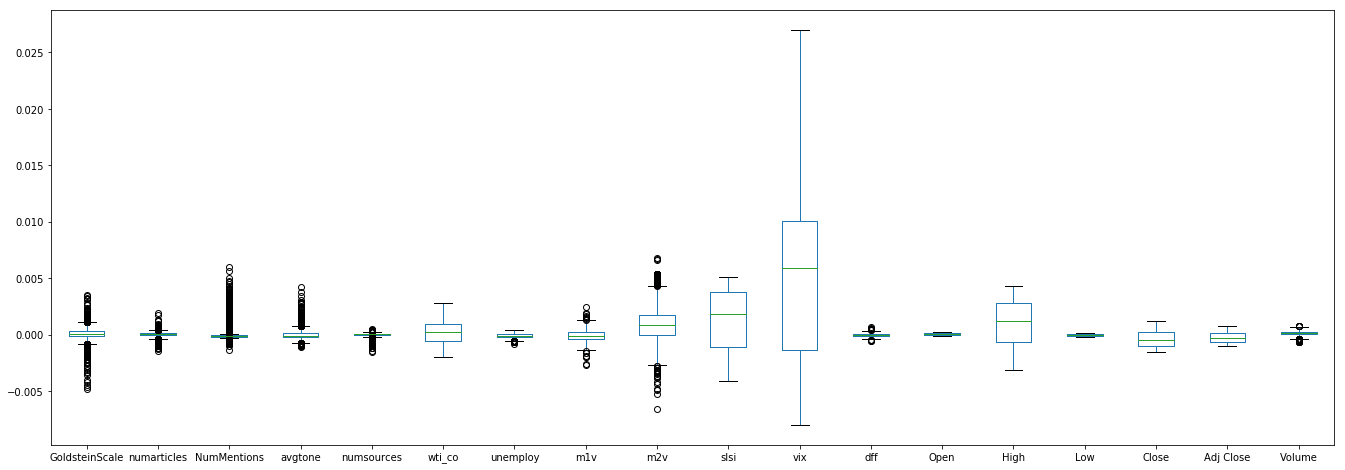

In [38]:
%pylab inline
pylab.rcParams['figure.figsize'] = (23, 8)
ig = np.array(intgrads_attrs)
ig_df = pd.DataFrame(ig.reshape(-1,D))
ig_df.columns = X_train_df.columns
ig_df.plot.box()

### Results
Integrated Gradients reveal that the GDELT features are not contributing much at all

In [39]:
ig_df.abs().mean().sort_values()

numsources        0.000083
Open              0.000093
Low               0.000094
dff               0.000108
numarticles       0.000135
unemploy          0.000161
Volume            0.000191
NumMentions       0.000232
avgtone           0.000268
m1v               0.000370
GoldsteinScale    0.000404
Adj Close         0.000452
Close             0.000700
wti_co            0.000711
m2v               0.001293
High              0.001900
slsi              0.002556
vix               0.006788
dtype: float32

## Integrated Gradients 2
#### https://github.com/hiranumn/IntegratedGradients/blob/master/IntegratedGradients.py

In [40]:
import IntegratedGradients as ig2 

In [41]:
int_grad = ig2.integrated_gradients(model=my_model)

Evaluated output channel (0-based index): All
Building gradient functions
Progress: 100.0%
Done.


In [42]:
int_grad_list = []
for i in range(len(X_train)):
    int_grad_list.append(int_grad.explain(X_train[i],num_steps=300).flatten())
    if i % 1000 == 0:
        print (i)

0
1000
2000
3000
4000
5000


In [43]:
feature_imp = pd.DataFrame(int_grad_list)
feature_imp.columns = X_train_df.columns

Populating the interactive namespace from numpy and matplotlib


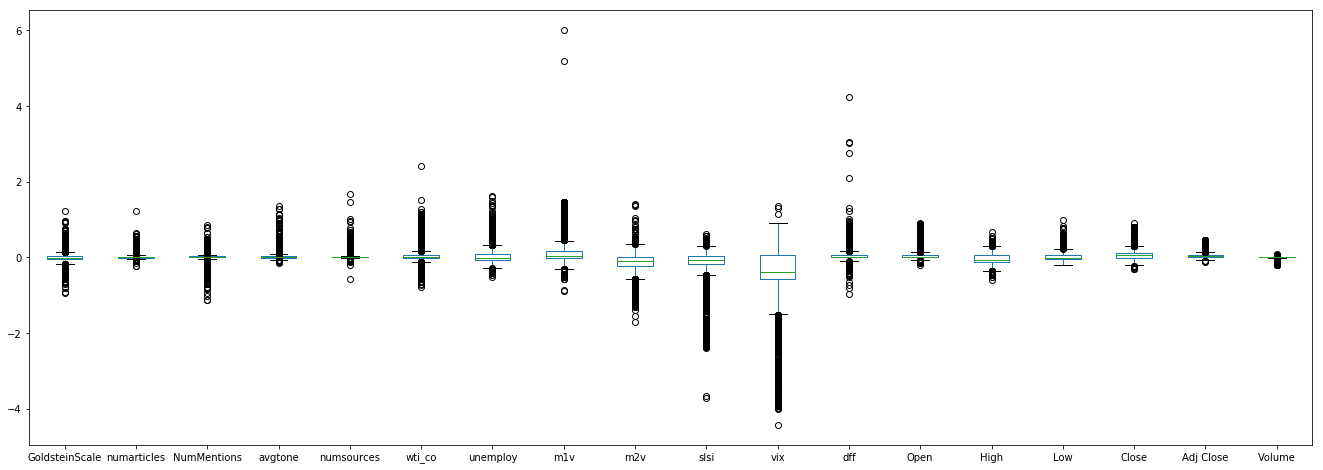

In [44]:
%pylab inline
pylab.rcParams['figure.figsize'] = (23, 8)
feature_imp.plot.box()

In [45]:
feature_imp.abs().mean().sort_values()

Volume            0.007826
numsources        0.024539
numarticles       0.025227
avgtone           0.038073
NumMentions       0.044597
Adj Close         0.053449
GoldsteinScale    0.067063
Open              0.068683
Low               0.077508
dff               0.082976
wti_co            0.090159
High              0.098485
Close             0.108424
unemploy          0.111372
m1v               0.154115
m2v               0.185978
slsi              0.187246
vix               0.501248
dtype: float64

## Results 2

The other code reveals a similar story with regard to GDELT, as it's not a heavily contributing set of features. However the order of the financial features differs slightly from my implementation